In [1]:
%pip install -q langchain langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 7.5 MB/s eta 0:00:00


In [2]:
# Пример профиля рабочего пространства пользователя

workspace_profile = {
    "organization_name": "ДИО-Консалт",
    "organization_type": "consulting",
    "description": """Компания «ДИО-Консалт» специализируется на внедрении комплексных корпоративных решений,
    предоставляя услуги по автоматизации бизнес-процессов на основе программных продуктов «1С»,
    независимо от сферы деятельности и от масштабов самого предприятия.""",
}

In [14]:
# Подключение к Yandex Foundation-models

import openai
from langchain_openai import ChatOpenAI

from google.colab import userdata

YANDEX_CLOUD_FOLDER_ID = userdata.get("YANDEX_CLOUD_FOLDER_ID")
YANDEX_CLOUD_APIKEY = userdata.get("YANDEX_CLOUD_APIKEY")
YANDEX_CLOUD_BASE_URL = "https://llm.api.cloud.yandex.net/v1"
SELECTED_MODEL = f"gpt://{YANDEX_CLOUD_FOLDER_ID}/yandexgpt/rc"  # YandexGPT Pro 5.1

yandexgpt_pro = ChatOpenAI(
    api_key=YANDEX_CLOUD_APIKEY,
    model=SELECTED_MODEL,
    base_url=YANDEX_CLOUD_BASE_URL,
    temperature=0.3,
    max_retries=3
)

In [15]:
# Тест работоспособности

yandexgpt_pro.invoke("Привет, какая LLM самая мощная на данный момент?")

AIMessage(content='На этот вопрос нет однозначного ответа, так как «мощность» большой языковой модели (LLM) можно оценивать по-разному: например, по размеру базы данных, количеству параметров, качеству генерации текста, скорости обработки запросов и другим критериям. Кроме того, развитие технологий идёт быстро, и ситуация на рынке постоянно меняется.\n\nНа момент конца 2023 года среди мощных и известных LLM можно назвать следующие:\n* **GPT-4** от OpenAI — модель, которая демонстрирует высокий уровень генерации текста, понимания контекста и выполнения сложных задач.\n* **Claude** от Anthropic — модель, ориентированная на безопасность и этичное использование ИИ.\n* **Llama 2** от Meta — модель с открытым исходным кодом, которая предлагает хорошие возможности для различных приложений и может быть дообучена под конкретные задачи.\n\nТакже стоит отметить, что в разных странах и регионах популярны различные модели, и в некоторых из них местные разработки могут превосходить зарубежные по опр

In [31]:
# Определение инструментов для агента 'опросника'

from langchain.tools import tool

customer_info: list[str] = []


@tool
def get_workspace_profile() -> dict[str, str]:
  """Получает информацию о рабочем пространстве пользователя,
  такую как название компании, описание и тип ораганизации
  """

  return workspace_profile


@tool
def save_customer_info(useful_note: str) -> None:
  """Сохранить информацию о клиенте в профиль.

  Attributes:
    useful_info: Полезная информация о клиенте полученная из его ответов
  """

  customer_info.append(useful_note)


@tool
def get_customer_info() -> str:
  """Получает текущую собранную информацию о клиенте"""

  return "\n\n".join(customer_info)


@tool
def finalize_interview(final_notes: str | None = None) -> None:
  """Завершение опроса и передаче данных на следующий этап.
  После вызовы этого интсрумента поблагадори пользователя за ответы.

  Attributes:
    final_notes: любые дополнительные комментарии,
    которые будут добавлены в портрет пользователя.
  """

  if final_notes is not None:
    customer_info.append(final_notes)


# Набор доступных инструментов
tools = [save_customer_info, get_customer_info, finalize_interview]
tools_by_name = {tool.name: tool for tool in tools}
yandexgpt_pro_with_tools = yandexgpt_pro.bind_tools(tools)

In [24]:
# Определение состояния

from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [25]:
import json

from langchain.messages import SystemMessage

prompt_path = "/content/prompts/Introductory_questions.md"

with open(prompt_path, "r", encoding="utf-8") as file:
  prompt = file.read()

system_message = prompt.format(workspace_profile=json.dumps(workspace_profile))


def llm_call(state: dict) -> ...:
  """LLM принимает решение о вызове инструмента"""

  return {
        "messages": [
            yandexgpt_pro_with_tools.invoke(
                [
                    SystemMessage(
                        content=system_message
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [26]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Выполнение вызова инструмента"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [27]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

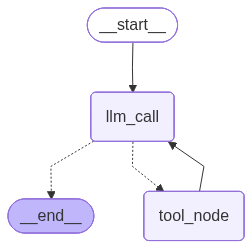

In [30]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile(checkpointer=checkpointer)

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [32]:
# Запуск агента


import json
from langchain.messages import HumanMessage, AIMessage
from IPython.display import display, Markdown

class AIDialogAgent:
    def __init__(self, agent, system_prompt: str):
        self.agent = agent
        self.system_prompt = system_prompt
        self.thread_id = "user_thread_1"  # Идентификатор сессии
        self.finalized = False  # Флаг завершения

    def format_response(self, messages: list) -> str:
        """Форматирование ответа для красивого отображения"""
        last_message = messages[-1]

        if hasattr(last_message, 'content'):
            response = last_message.content

            # Добавляем инструменты, если они были вызваны
            if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
                tools_used = []
                for tool_call in last_message.tool_calls:
                    tools_used.append(f"📝 Использован инструмент: **{tool_call['name']}**")

                if tools_used:
                    response += "\n\n" + "\n".join(tools_used)

            return response

        return ""

    def check_finalized(self, messages: list) -> bool:
        """Проверка, был ли вызван finalize_interview"""
        for message in messages:
            if hasattr(message, 'tool_calls'):
                for tool_call in message.tool_calls:
                    if tool_call['name'] == 'finalize_interview':
                        return True
        return False

    def run_dialog(self):
        """Запуск диалогового цикла"""
        print("🤖 ИИ-консультант: Здравствуйте! Я помогу подобрать оптимальную конфигурацию сервера для ваших AI-задач.\n")

        # Инициализация состояния с системным промптом
        initial_state = {
            "messages": [SystemMessage(content=self.system_prompt)],
            "llm_calls": 0
        }

        # Запускаем агента для первого сообщения
        result = self.agent.invoke(
            initial_state,
            config={"configurable": {"thread_id": self.thread_id}}
        )

        # Показываем первый вопрос
        first_response = self.format_response(result["messages"])
        display(Markdown(f"**🤖 Агент:** {first_response}"))

        # Основной диалоговый цикл
        while not self.finalized:
            try:
                # Получаем ввод пользователя
                user_input = input("\n**👤 Вы:** ").strip()

                if not user_input:
                    print("Пожалуйста, введите сообщение.")
                    continue

                # Добавляем сообщение пользователя
                result = self.agent.invoke(
                    {"messages": [HumanMessage(content=user_input)]},
                    config={"configurable": {"thread_id": self.thread_id}}
                )

                # Проверяем завершение
                self.finalized = self.check_finalized(result["messages"])

                # Форматируем и показываем ответ
                response = self.format_response(result["messages"])
                if response:
                    display(Markdown(f"\n**🤖 Агент:** {response}"))

                # Если агент завершил работу
                if self.finalized:
                    print("\n" + "="*50)
                    print("✅ Опрос завершен! Собранная информация:")
                    print("="*50)
                    print(get_customer_info())
                    print("\n📊 Передаю данные в модуль подбора конфигурации...")
                    break

            except KeyboardInterrupt:
                print("\n\n👋 Диалог прерван пользователем.")
                break
            except Exception as e:
                print(f"\n⚠️ Произошла ошибка: {e}")
                break

# Запускаем агента
dialog_agent = AIDialogAgent(agent, system_message)
dialog_agent.run_dialog()

🤖 ИИ-консультант: Здравствуйте! Я помогу подобрать оптимальную конфигурацию сервера для ваших AI-задач.



**🤖 Агент:** Здравствуйте! Расскажите, пожалуйста, о вашей задаче простыми словами. Чего вы хотите достичь с помощью ИИ?


**👤 Вы:** Хочу автоматизировать ответы на популярные вопросы клиентов



**🤖 Агент:** Отлично! Эти ответы будут браться из вашей базы знаний или нужны общие ответы? Есть ли у вас, например, FAQ или инструкции по продуктам?


**👤 Вы:** Да есть, они хранятся в внутреннем документообороте



**🤖 Агент:** Понял. Сколько людей будут пользоваться этой системой?

- Только я/несколько человек;
- Отдел (10-50 человек);
- Вся компания (сотни);
- Внешние клиенты (тысячи+).


**👤 Вы:** Несколько отделов



**🤖 Агент:** На каких языках должна работать система?

- Только русский;
- Русский + английский;
- Несколько языков (европейские);
- Много языков (включая азиатские).


**👤 Вы:** Только русский



**🤖 Агент:** С какими данными будет работать система?

- Публичная информация (сайты, справочники);
- Наши внутренние документы (инструкции, база знаний);
- Конфиденциальные данные (финансовые, персональные);
- Секретные/коммерческая тайна.


**👤 Вы:** Как внутренние документы так и потенциально секретные



**🤖 Агент:** Можно ли передавать эти данные в публичные сервисы (типа ChatGPT)?

- Да, можно;
- Нет, данные должны оставаться у нас;
- Не знаю, нужно посоветоваться.


**👤 Вы:** Нет



**🤖 Агент:** Какой формат бюджета предпочтительнее?

- Ежемесячные платежи (как подписка);
- Разовые инвестиции в оборудование;
- Смешанный вариант;
- Нужен самый бюджетный вариант.


**👤 Вы:** Мне нужен самый оптимальный вариант по цене и качеству



**🤖 Агент:** Насколько важна скорость ответов для вас?

- Не критично, может думать несколько секунд;
- Желательно 2–3 секунды;
- Максимально быстро (менее секунды);
- Для фоновых задач, можно минуты.


**👤 Вы:** Не критична



**🤖 Агент:** Правильно ли я понял, что вам нужна система, которая будет автоматизировать ответы на вопросы клиентов с использованием вашей внутренней базы знаний и инструкций? Система должна работать на русском языке, обрабатывать внутренние и потенциально конфиденциальные данные, при этом данные не должны покидать вашу инфраструктуру. Скорость ответа не критична, и вы ищете оптимальное соотношение цены и качества?


**👤 Вы:** да



**🤖 Агент:** Спасибо за ваши ответы! Мы учтём все ваши пожелания и подготовим для вас оптимальное решение.


✅ Опрос завершен! Собранная информация:

⚠️ Произошла ошибка: 'StructuredTool' object is not callable


In [33]:
# Собранная информация

customer_info

['Задача: автоматизация ответов на вопросы клиентов с использованием внутренней базы знаний и инструкций. Целевая аудитория: несколько отделов компании. Язык: только русский. Работа с внутренними и потенциально конфиденциальными данными, требование о неразмещении данных в публичных сервисах. Скорость ответа не критична. Ищет оптимальное соотношение цены и качества. Требование: данные не должны покидать инфраструктуру компании.',
 'Пользователь заинтересован в решении для автоматизации клиентской поддержки с учетом конфиденциальности данных и без жестких требований к скорости ответа. Важен баланс цены и качества.']